# Case Study 1: Sonar

This notebook builds a Nearest Neighbour classifier using the Minkowski distance. We use sonar data to tell apart rock objects and metal cylinders. We work with a training set and a test set.

## Overview

### Objective
Our goal is to write code that:

- Computes the Minkowski distance between test records and training records.
- Finds the closest match from the training set for each test record.
- Assigns the class of that closest record to the test record.
- Measures the accuracy, recall, precision, and F1 score for the predictions. We treat the metal class ("M") as the positive class.
- Tests the classifier with q values from 1 to 20, including the Manhattan (q = 1) and Euclidean (q = 2) distances.

### Dataset
- **Sonar Dataset:** Contains 60 predictors (A1, A2, …, A60) representing sonar signal measurements.
- **Target Variable:** "Class" – labels objects as either a rock ("R") or a metal cylinder ("M").

### Tasks
1. Write code that computes the Minkowski distance between records.
2. For each test record, find the nearest record in the training set.
3. Assign the class of the nearest record as the predicted class.
4. Calculate and display the accuracy, recall, precision, and F1 score on the test set.
5. Run the code for q values from 1 to 20 and plot the performance measures. Identify which q value gives the best accuracy.

## Data Loading and Preprocessing
We begin by importing the necessary libraries and setting a random seed to ensure reproducibility. Next, we load the training and test datasets using Pandas. We then separate the features from the target variable. Finally, we standardise the data so that each feature contributes fairly to the distance calculation.

In [2]:
import pandas as pd 
import numpy as np

np.random.seed(42)

In [3]:
# Load Sonar datasets
train_data = pd.read_csv("sonar_train.csv")
test_data = pd.read_csv("sonar_test.csv")

# Separate features and targets from train and test data
train_X = train_data.drop(columns=["Class"])
train_y = train_data[["Class"]].to_numpy().flatten()

test_X = test_data.drop(columns=["Class"])
test_y = test_data[["Class"]].to_numpy().flatten()

# Display summary of training feature statistics
train_X.describe()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A51,A52,A53,A54,A55,A56,A57,A58,A59,A60
count,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,...,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,0.028881,0.037319,0.041682,0.052694,0.075263,0.105000,0.123863,0.132810,0.175160,0.205400,...,0.016472,0.013347,0.010170,0.010484,0.009495,0.008061,0.007673,0.008077,0.007858,0.006549
std,0.022602,0.033011,0.038513,0.047588,0.056174,0.057755,0.061604,0.087889,0.120416,0.126882,...,0.012275,0.010252,0.007068,0.006864,0.007135,0.006076,0.005402,0.006803,0.006001,0.004598
min,0.001500,0.001700,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.019300,...,0.001500,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000600,0.000100,0.000600
25%,0.013150,0.015800,0.017050,0.024400,0.039200,0.071950,0.086800,0.082650,0.094000,0.110300,...,0.008700,0.006800,0.004650,0.005350,0.004100,0.003950,0.003700,0.003550,0.003550,0.003100
50%,0.022100,0.029700,0.032400,0.041500,0.061700,0.092900,0.105300,0.111700,0.152200,0.183800,...,0.014000,0.011300,0.008400,0.008900,0.007900,0.006400,0.006200,0.005800,0.006500,0.005400
75%,0.035250,0.047550,0.055600,0.062700,0.101050,0.132550,0.160700,0.167600,0.226500,0.269000,...,0.020800,0.016450,0.013550,0.013500,0.012100,0.010150,0.010350,0.010650,0.010050,0.008750
max,0.131300,0.233900,0.305900,0.426400,0.401000,0.307000,0.332200,0.459000,0.682800,0.596600,...,0.100400,0.070900,0.036100,0.035200,0.044700,0.039400,0.035500,0.044000,0.029400,0.023100


We define a function to standardise the data. This function subtracts the mean and divides by the standard deviation for each feature.

In [4]:
def standardise_data(X : pd.DataFrame) -> np.ndarray:
    """
    A preprocessing function that standardises the data in a DataFrame 
    (mean = 0, s.d. = 1), returning it as an ndarray.
    """
    for col in X:
        X[col] = (X[col] - X[col].mean()) / X[col].std()
    return X.to_numpy()

In [5]:
prepared_train_X = standardise_data(train_X)
prepared_test_X = standardise_data(test_X)

prepared_train_X

array([[-0.92829719, -0.86999683, -0.93948343, ..., -0.33471482,
        -0.32622946, -0.72831973],
       [ 1.37239273,  0.30537063,  0.21078741, ...,  0.48848271,
         0.55702391,  0.750537  ],
       [-0.86635553, -0.31563537, -0.51884263, ...,  0.51788262,
        -0.3095643 ,  0.96801594],
       ...,
       [-1.21145902, -0.56706707, -0.33189116, ..., -1.0403127 ,
        -0.77618872, -0.40210133],
       [ 0.54060483, -0.29140099,  0.48602151, ..., -0.45231447,
         0.10706465, -0.46734501],
       [-0.08323608, -0.63674091, -0.19687065, ...,  0.19448359,
         0.44036781,  0.59830175]])

## Nearest Neighbour Implementation

This section explains the construction of a Nearest Neighbour classifier that uses the Minkowski distance. The classifier finds the closest training record for each test record and assigns its class label accordingly.

### NearestNeighbourClassifier Model
We encapsulate the classifier in a NearestNeighbourClassifier class. The class includes:

- **Initialisation**: Sets the Minkowski power (q) to a default value of 2 (Euclidean distance).

- **Fit Method**: Saves the training features and corresponding labels.

- **Predict Method**: Iterates over each test record, calculates the Minkowski distance to every training record, and selects the training record with the smallest distance. The class label of the nearest training record becomes the prediction.

- **Distance Calculation**: The helper method `_minkowski_dist` computes the Minkowski distance between two vectors using a given power `q`. It traverses both vectors, summing the absolute differences between their respective elements raised to the power of `q`. The qth root of the sum is then taken before finally returning the resultant distance value.

In [6]:
class NearestNeighbourClassifier():
    """
    Implements the Nearest Neighbour algorithm for binary classification.

    Parameters
    ----------
    minkowski_q : int, default=2
        The power q to use in the Minkowski distance calculation.

    Methods
    -------
    fit(X, y)
        Fit the model to the passed features (X) and targets (y).
    predict(X)
        Find the nearest neighbour from fitted data for all samples in X,
        returning an ndarray of predicted labels.
    """
    def __init__(self, minkowski_q=2): # Euclidean distance by default
        """The constructor for the NearestNeighbourClassifier class."""
        self.minkowski_q = minkowski_q

    def fit(self, X : np.ndarray, y : np.ndarray):
        """Fit the model to the passed features (X) and targets (y)."""
        self.X_ = X
        self.y_ = y

        return self
    
    def predict(self, X : np.ndarray) -> np.ndarray:
        """
        Find the nearest neighbour from fitted data for all samples in X,
        returning an ndarray of predicted labels.
        """
        preds = []
        # Iterate over each sample
        for sample in X:
            dists = []
            # Find Minkowski distance between the sample and all fitted data
            for fit_sample in self.X_:
                dists.append(self._minkowski_dist(sample, fit_sample, self.minkowski_q))

            # Get index of fitted data sample with smallest distance (nearest neighbour)
            nearest_neighbour_index = np.argmin(dists) 
            
            # Append nearest neighbour's label to the predictions
            preds.append(self.y_[nearest_neighbour_index])
            
        return np.array(preds)
    
    def _minkowski_dist(self, array1 : np.ndarray, array2 : np.ndarray, q : int) -> float:
        """Compute the Minkowski distance between two vectors using a given power q."""
        dist = 0
        for feature1, feature2 in zip(array1, array2):
            dist += np.abs(feature1 - feature2)**q

        return dist**(1/q)

### Classification Performance Metrics

To assess our classifier, we implement functions for common performance metrics. These metrics help us understand different aspects of our model's performance:

- **Accuracy**:  
  Accuracy is the fraction of correct predictions among all predictions. It is calculated as the number of correct predictions divided by the total number of predictions. Accuracy is useful because it provides a quick snapshot of overall performance. 

- **Precision**:  
  Precision measures the ratio of correct positive predictions to all positive predictions made by the model. In other words, it tells us how many of the instances that the model labeled as positive (e.g., metal cylinders) were actually positive. This metric is particularly useful when the cost of false positives is high. 

- **Recall**:  
  Recall, also known as sensitivity, is the ratio of correct positive predictions to all actual positive cases. It evaluates how well the model captures all the positive instances in the data. Recall is important when missing a positive case is critical.

- **F1 Score**:  
  The F1 score is the harmonic mean of precision and recall. It provides a single measure that balances both the concerns of precision and recall. The F1 score is especially useful when you need to balance the trade-off between precision and recall, or when the class distribution is uneven. It ensures that a model does not excel in one metric at the expense of the other.


**Accuracy Score**

The rate of true predictions out of all predictions made. `(TP + TN) / P`

In [7]:
def accuracy_score(y_true : np.ndarray, y_preds : np.ndarray) -> float:
    """Calculate the accuracy rate for predicted labels."""
    total_preds = y_preds.size
    true_preds = 0

    for pred_label, true_label in zip(y_preds, y_true):
        if pred_label == true_label : true_preds += 1

    return true_preds/total_preds

**Precision Score**

The rate of true positive predictions out of all positive predictions made. `TP / (TP + FP)`

In [ ]:
def precision_score(y_true : np.ndarray, y_preds : np.ndarray, pos_label) -> float:
    """Calculate the precision rate for predicted labels."""
    true_positive = 0
    positive = 0

    for pred_label, true_label in zip(y_preds, y_true):
        if pred_label != pos_label : continue

        if pred_label == true_label : true_positive += 1
        
        positive += 1
    
    if positive == 0 : return 0 # Avoid divide by zero error

    return true_positive/positive

**Recall Score**

The rate of true positive predictions out of all actual positives. `TP / (TP + FN)`

In [ ]:
def recall_score(y_true : np.ndarray, y_preds : np.ndarray, pos_label) -> float:
    """Calculate the recall/sensitivity rate for predicted labels."""
    true_positive = 0
    pred_positive = 0

    for pred_label, true_label in zip(y_preds, y_true):
        if true_label != pos_label : continue

        if pred_label == true_label : true_positive += 1
        
        pred_positive += 1

    if pred_positive == 0 : return 0 # Avoid divide by zero error

    return true_positive/pred_positive

**F1 Score**

The harmonic mean of the precision and recall rates. `2 / (1/precision + 1/recall)`

In [10]:
def f1_score(y_true : np.ndarray, y_preds : np.ndarray, pos_label) -> float:
    """Calculate the F1 score for predicted labels."""
    precision = precision_score(y_true, y_preds, pos_label)
    recall = recall_score(y_true, y_preds, pos_label)

    if precision == 0 or recall == 0 : return 0 # Avoid divide by zero error

    return 2 / (1/precision + 1/recall)

**All Binary Classification Scores**

A simple function is defined that takes all of the above mentioned classification performance measures, returning the results in a tuple.

In [11]:
def binary_classification_scores(y_true : np.ndarray, y_preds : np.ndarray, pos_label) -> tuple:
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, pos_label)
    recall = recall_score(y_true, y_preds, pos_label)
    f1 = f1_score(y_true, y_preds, pos_label)

    return (accuracy, precision, recall, f1)

### Evaluating the Classifier on the Test Set
We now test the classifier on the preprocessed test data. We vary the Minkowski power q from 1 to 20. For each value of `q`, we:

- Update the Minkowski power.
- Predict the labels for the test set.
- Compute and print the performance metrics.
- Record the results in a `history` dict for later visualisation.

In [13]:
nearest_neighbour = NearestNeighbourClassifier()
nearest_neighbour.fit(prepared_train_X, train_y)

print("Measuring Performance on Test Set for Minkowski q values from 1-20")
print("-" * 100)

q_values = list(range(1, 21))

history = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}

for q in q_values:
    nearest_neighbour.minkowski_q = q

    print(f"\nMinkowski power q: {q}\n")

    preds = nearest_neighbour.predict(prepared_test_X)

    # Get all performance scores using "M" as the positive class
    scores = binary_classification_scores(test_y, preds, pos_label="M")
    
    history["accuracy"].append(scores[0])
    history["precision"].append(scores[1])
    history["recall"].append(scores[2])
    history["f1"].append(scores[3])

    # Print performance scores
    print("Accuracy:", round(scores[0], 3))
    print("Precision:", round(scores[1], 3))
    print("Recall:", round(scores[2], 3))
    print("F1 score:", round(scores[3], 3))

Measuring Performance on Test Set for Minkowski q values from 1-20
----------------------------------------------------------------------------------------------------

Minkowski power q: 1

Accuracy: 0.942
Precision: 0.923
Recall: 0.973
F1 score: 0.947

Minkowski power q: 2

Accuracy: 0.899
Precision: 0.875
Recall: 0.946
F1 score: 0.909

Minkowski power q: 3

Accuracy: 0.899
Precision: 0.857
Recall: 0.973
F1 score: 0.911

Minkowski power q: 4

Accuracy: 0.855
Precision: 0.829
Recall: 0.919
F1 score: 0.872

Minkowski power q: 5

Accuracy: 0.855
Precision: 0.829
Recall: 0.919
F1 score: 0.872

Minkowski power q: 6

Accuracy: 0.841
Precision: 0.81
Recall: 0.919
F1 score: 0.861

Minkowski power q: 7

Accuracy: 0.826
Precision: 0.791
Recall: 0.919
F1 score: 0.85

Minkowski power q: 8

Accuracy: 0.841
Precision: 0.81
Recall: 0.919
F1 score: 0.861

Minkowski power q: 9

Accuracy: 0.841
Precision: 0.81
Recall: 0.919
F1 score: 0.861

Minkowski power q: 10

Accuracy: 0.812
Precision: 0.8
Recall:

### Visualisation of Results
We use Matplotlib to create plots that show how each performance metric changes with the Minkowski power   `q`. The visualisations help us observe trends in accuracy, precision, recall, and F1 score as we adjust `q`, thus identifying the value that provides optimal performance.

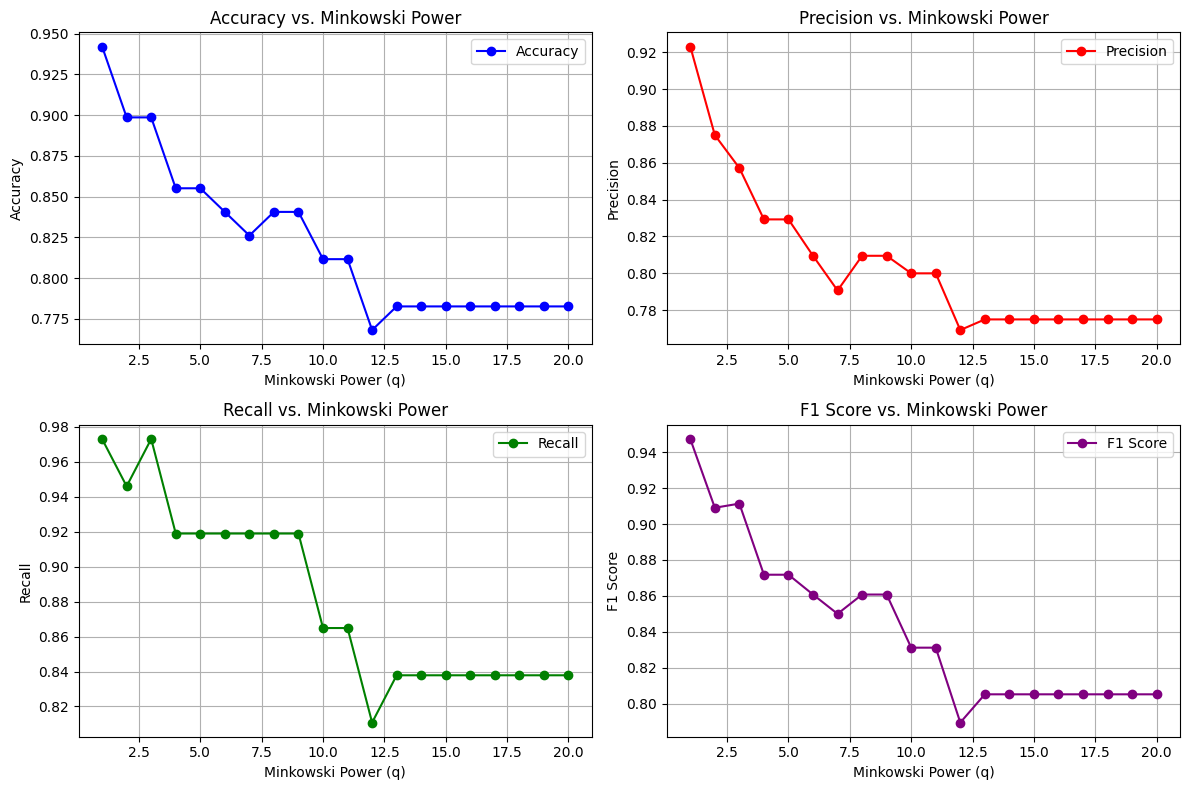

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(q_values, history["accuracy"], marker='o', color='blue', label="Accuracy")
plt.xlabel("Minkowski Power (q)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Minkowski Power")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(q_values, history["precision"], marker='o', color='red', label="Precision")
plt.xlabel("Minkowski Power (q)")
plt.ylabel("Precision")
plt.title("Precision vs. Minkowski Power")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(q_values, history["recall"], marker='o', color='green', label="Recall")
plt.xlabel("Minkowski Power (q)")
plt.ylabel("Recall")
plt.title("Recall vs. Minkowski Power")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(q_values, history["f1"], marker='o', color='purple', label="F1 Score")
plt.xlabel("Minkowski Power (q)")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Minkowski Power")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

From the visulisation, we can see how these plots relate to the numerical results:

**Peak Performance at \(q=1\)** 
- The highest accuracy (0.942) appears when \(q=1\), along with strong precision (0.923), recall (0.973), and F1 (0.947). This indicates that the **Manhattan distance** (i.e., \(q=1\)) allows the classifier to perform best overall on this sonar dataset.

**Performance Dips as \(q\) Increases**
- At \(q=2\) and \(q=3\), accuracy remains solid (around 0.899) but is noticeably lower than at \(q=1\). Precision and recall also start to drop, though recall stays fairly high (above 0.94) at \(q=2\) and \(q=3\).
- Once \(q\) moves to 4 or 5, accuracy settles around 0.855, with a decrease in precision, recall, and F1.

**Stabilisation at Higher \(q\) Values**
- Between \(q=12\) and \(q=20\), accuracy levels off at around 0.768–0.783, and F1 remains around 0.789–0.805. Precision, recall, and F1 remain consistent in this range, but they are all lower compared to the performance at \(q=1\).

Overall, these observations show that the best results occur at \(q=1\), and as \(q\) grows larger, the classifier’s metrics decline and eventually stabilise. This suggests that **Manhattan distance** (when \(q=1\)) is most effective for this particular task, while higher powers in the Minkowski distance lead to lower accuracy, precision, recall, and F1 scores.


## Summary

In this notebook, we built a Nearest Neighbour classifier that uses the Minkowski distance to distinguish between rock objects and metal cylinders based on sonar data. Our process began by loading the training and test datasets and standardising the features. This standardisation ensured that each of the 60 predictors contributed equally to the distance calculations, which is essential when features operate on different scales.

We then implemented the classifier from scratch. This involved manually coding the Minkowski distance computation so that we could adjust the power parameter `q` and observe its effect on performance. For each test record, the classifier calculated the distance to every training record, identified the closest one, and used that record’s class label as the prediction.

To evaluate the classifier, we computed several performance metrics: accuracy, precision, recall, and F1 score. These metrics provided a comprehensive view of how well the classifier performed overall and how effectively it identified the metal cylinders (the positive class). We varied the Minkowski power `q` from 1 to 20, recording the performance for each value.

By visualising the results, we observed clear trends. The best performance was achieved at q=1 (Manhattan distance), with high accuracy, precision, recall, and F1 score. As `q` increased, the metrics gradually declined and eventually stabilised at lower values. This detailed analysis shows that the choice of `q` significantly impacts the classifier's performance and helps in selecting the optimal parameter for the sonar classification task.
